# Testing for a relationship between centrality and popularity

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import pydot
import itertools

## Construct a graph using recent movies

In [2]:
df_roles = pd.read_pickle("../data/generated/preprocessed/roles.pkl")
df_roles.head(1)

,wiki_id,fb_movie_id,release,character_name,actor_age,fb_char_id,fb_actor_id,release_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,42.0,/m/0bgchxw,/m/03wcfv7,2001


In [3]:
edges = []

recent_roles = df_roles.loc[df_roles.release_year >= 2005].dropna(subset=['fb_actor_id'])

for movie_fbid, df_actor_movie in recent_roles.groupby('fb_movie_id'):
	# NOTE : we need to sort the edges, because we only store i -> j, but want an undirected graph
	# NOTE : we need to use unique(), because some actors play multiple characters in the same movie
	# e.g. df_actors.query('fb_movie_id == "/m/011xrr"')
	edges += [ (*sorted((actor1_fbid, actor2_fbid)), movie_fbid )
		for actor1_fbid, actor2_fbid 
              in itertools.combinations(df_actor_movie.fb_actor_id.unique(), r=2) ]

df_edges = pd.DataFrame(edges, columns=['actor1_fbid', 'actor2_fbid', 'movie_fbid'])

# sanity check that we indeed have ordered edges
assert (df_edges['actor1_fbid'] < df_edges['actor2_fbid']).all()
df_edges

,actor1_fbid,actor2_fbid,movie_fbid
0,/m/01515w,/m/01pkhw,/m/01_0f7
1,/m/01515w,/m/0ch1tl5,/m/01_0f7
2,/m/01515w,/m/0523xrr,/m/01_0f7
3,/m/01515w,/m/07lf49,/m/01_0f7
4,/m/01515w,/m/03jj93,/m/01_0f7
...,...,...,...
706897,/m/0c33pl,/m/0cp4b5,/m/0n4zpt9
706898,/m/05tb_b,/m/0cp4b5,/m/0n4zpt9
706899,/m/07p6t8,/m/0c33pl,/m/0n4zpt9
706900,/m/05tb_b,/m/07p6t8,/m/0n4zpt9


In [4]:
df_edges_grouped = (df_edges
	.groupby(['actor1_fbid', 'actor2_fbid'])
	[['movie_fbid']]
	.count()
	.reset_index()
	.sort_values('movie_fbid', ascending=False)  # movie_fbid count is the edge weight !!
)
df_edges_grouped.rename(columns={'movie_fbid': 'movie_count'}, inplace=True)
df_edges_grouped.head(10)

,actor1_fbid,actor2_fbid,movie_count
175796,/m/02qnyr7,/m/071wvh,42
189813,/m/02rzmzk,/m/071wvh,38
304750,/m/047s_cr,/m/071wvh,31
425539,/m/071wvh,/m/09tqx3,29
178194,/m/02qvhbb,/m/071wvh,28
238573,/m/03chx58,/m/071wvh,27
175740,/m/02qnyr7,/m/02rzmzk,24
238737,/m/03chxc3,/m/071wvh,23
174276,/m/02ql_ms,/m/071wvh,21
425597,/m/071wvh,/m/0fr7nt,19


In [5]:
df_actors = pd.read_pickle("../data/generated/preprocessed/actors.pkl")
df_actors = df_actors.loc[df_actors.actor_name.notna()]
actor_graph = nx.from_pandas_edgelist(df_edges_grouped, source='actor1_fbid', target='actor2_fbid', edge_attr=['movie_count'])
actor_graph = actor_graph.subgraph(df_actors.fb_actor_id).copy()

In [6]:
# a mapping from freebaseid to actor names
fbid2name = dict((row.fb_actor_id, row.actor_name) for _, row in df_actors.iterrows())
fbid2name_newline = dict((row.fb_actor_id, row.actor_name.replace(' ', '\n')) for _, row in df_actors.iterrows())  # for displaying graphs

actor_graph_names = nx.relabel_nodes(actor_graph, fbid2name)

## Selecting the largest connected componnent

In [7]:
# create a list of connected components
actor_graph_comps = [actor_graph.subgraph(c).copy() for c in nx.connected_components(actor_graph)]

In [8]:
actor_subgraph = max(actor_graph_comps, key=lambda G: G.number_of_nodes())
print(actor_subgraph)

Graph with 49481 nodes and 653771 edges


In [9]:
actor_subgraph_names = nx.relabel_nodes(actor_subgraph, fbid2name_newline)

## Computing centrality

In [10]:
degree_centrality = nx.degree_centrality(actor_subgraph)

In [11]:
eigenvector_centrality = nx.eigenvector_centrality(actor_subgraph)

In [12]:
betweenness_centrality = nx.betweenness_centrality(actor_subgraph, k=300)

In [13]:
df_centrality = pd.DataFrame(degree_centrality.items(), columns=['fb_actor_id', 'degree_centrality'])
df_centrality = df_centrality.merge(pd.DataFrame(eigenvector_centrality.items(), columns=['fb_actor_id', 'eigenvector_centrality']), on='fb_actor_id', how='left')
df_centrality = df_centrality.merge(pd.DataFrame(betweenness_centrality.items(), columns=['fb_actor_id', 'betweenness_centrality']), on='fb_actor_id', how='left')
df_centrality['actor_name'] = df_centrality.fb_actor_id.map(lambda i: fbid2name[i])

### Who are the top actors ?

In [14]:
df_centrality.sort_values('degree_centrality', ascending=False)[['degree_centrality', 'actor_name', 'fb_actor_id']].head(5)

,degree_centrality,actor_name,fb_actor_id
70,0.011601,Anupam Kher,/m/0292l3
744,0.010853,Jane Lynch,/m/07m77x
748,0.010287,Samuel L. Jackson,/m/0f5xn
710,0.009903,David Koechner,/m/059j1m
202,0.009863,Justin Long,/m/07cjqy


In [15]:
df_centrality.sort_values('eigenvector_centrality', ascending=False)[['eigenvector_centrality', 'actor_name']].head(5)

,eigenvector_centrality,actor_name
1150,0.095907,David Strathairn
6434,0.095699,Nicole Kidman
4889,0.095603,Clive Owen
6102,0.094613,Parker Posey
4467,0.094151,Rodrigo Santoro


In [16]:
df_centrality.sort_values('betweenness_centrality', ascending=False)[['betweenness_centrality', 'actor_name']].head(5)

,betweenness_centrality,actor_name
70,0.016426,Anupam Kher
1032,0.013458,Stellan Skarsgård
256,0.010464,Irrfan Khan
28,0.009304,Om Puri
313,0.009173,Michael Madsen


## Popularity through wikipedia pageviews

In [17]:
df_actors.index = df_actors.fb_actor_id

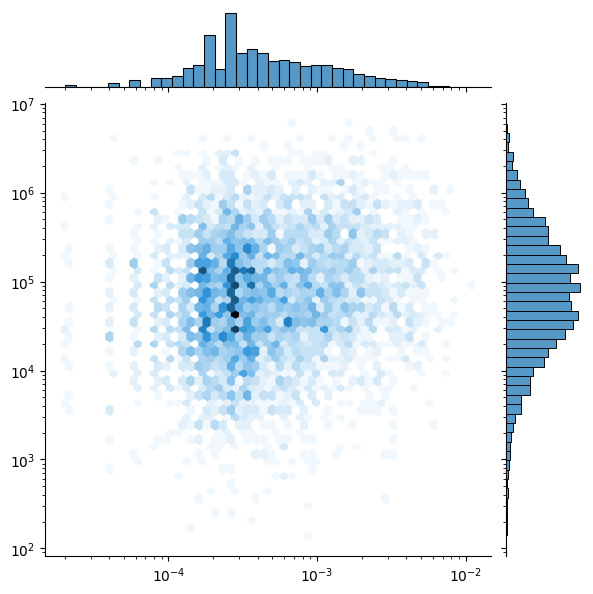

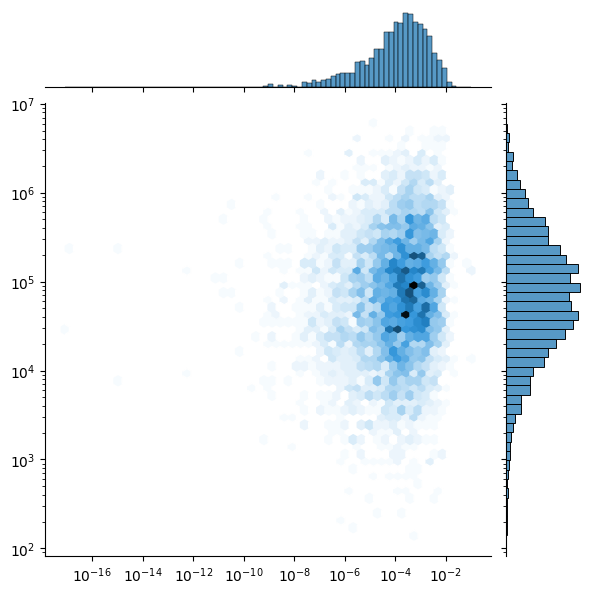

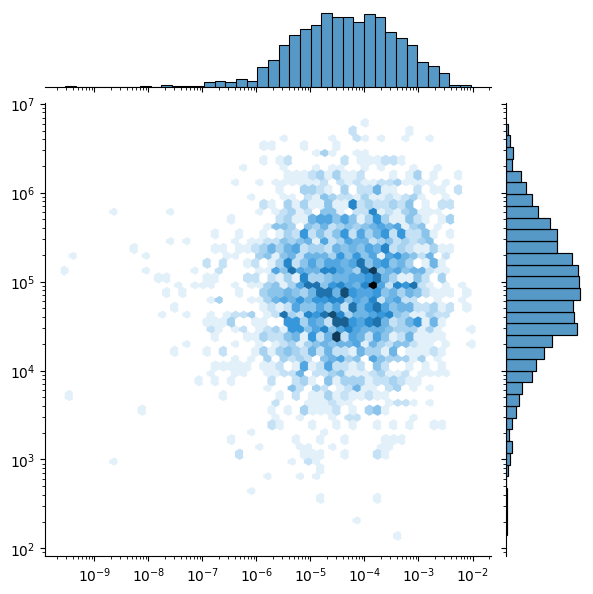

In [18]:
for c, t in zip([degree_centrality, eigenvector_centrality, betweenness_centrality], ['degree_centrality', 'eigenvector_centrality', 'betweenness_centrality']):
    centrality = [c[node] for node in actor_subgraph.nodes() if not pd.isna(df_actors.pageviews[node]) and c[node] > 0]
    pageviews = [df_actors.pageviews[node] for node in actor_subgraph.nodes() if not pd.isna(df_actors.pageviews[node]) and c[node] > 0]
    sns.jointplot(x=centrality, y=pageviews, kind="hex", xscale="log", yscale="log")

### Check relationship between centrality and the number of movies

In [19]:
df_roles

,wiki_id,fb_movie_id,release,character_name,actor_age,fb_char_id,fb_actor_id,release_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,42.0,/m/0bgchxw,/m/03wcfv7,2001
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,27.0,/m/0jys3m,/m/0346l4,2001
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,32.0,/m/0jys3g,/m/01vw26l,2001
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,33.0,/m/02vchl6,/m/034hyc,2001
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,23.0,/m/02vbb3r,/m/01y9xg,2001
...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,NaN,/m/0kr406c,/m/0b_vcv,1992
450665,913762,/m/03pcrp,1992-05-21,Hibiki,27.0,/m/0kr405_,/m/0bx7_j,1992
450666,28308153,/m/0cp05t9,1957,NaN,15.0,/m/0g8ngmc,/m/022g44,1957
450667,28308153,/m/0cp05t9,1957,NaN,NaN,/m/0g8ngmj,/m/0g8ngmm,1957


In [20]:
movie_counts = df_roles.groupby(by=["fb_actor_id"]).fb_movie_id.nunique()
df_actors["movie_count"] = movie_counts

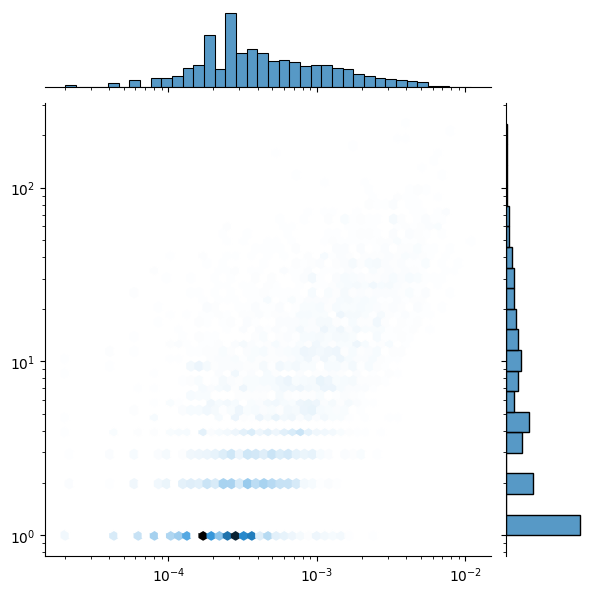

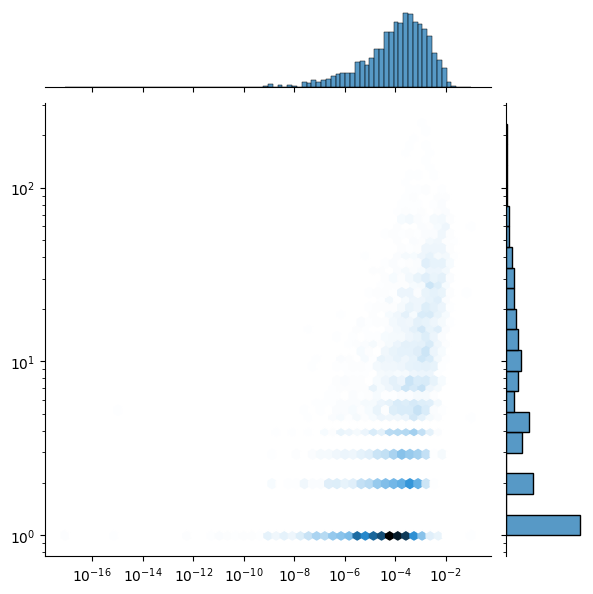

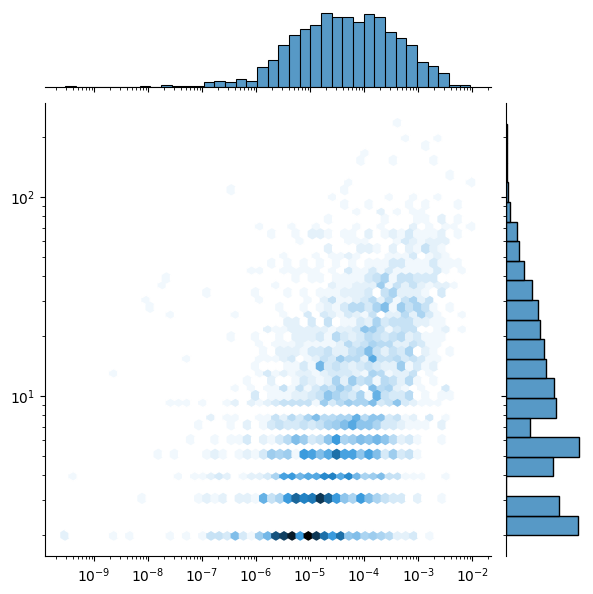

In [21]:
for c, t in zip([degree_centrality, eigenvector_centrality, betweenness_centrality], ['degree_centrality', 'eigenvector_centrality', 'betweenness_centrality']):
    centrality = [c[node] for node in actor_subgraph.nodes() if not pd.isna(df_actors.pageviews[node]) and c[node] > 0]
    movies = [df_actors.movie_count[node] for node in actor_subgraph.nodes() if not pd.isna(df_actors.pageviews[node]) and c[node] > 0]
    sns.jointplot(x=centrality, y=movies, kind="hex", xscale="log", yscale="log")

In [22]:
df_centrality = df_centrality.drop("actor_name", axis=1)
df_actors = df_actors.reset_index(drop = True)

In [23]:
df_central_actors = pd.merge(df_actors, df_centrality, on="fb_actor_id")
df_central_actors = df_central_actors.reset_index(drop = True)
df_central_actors

,fb_actor_id,actor_name,actor_birth,ethnicity,actor_height,actor_gender,actor_nationality,pageviews,movie_count,degree_centrality,eigenvector_centrality,betweenness_centrality
0,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.620,F,United States of America,NaN,8,0.000485,0.000319,0.000003
1,/m/0346l4,Natasha Henstridge,1974-08-15,NaN,1.780,F,Canada,208978.0,20,0.001293,0.000998,0.000294
2,/m/01vw26l,Ice Cube,1969-06-15,NaN,1.727,M,United States of America,713128.0,33,0.002829,0.003777,0.000316
3,/m/034hyc,Jason Statham,1967-09-12,NaN,1.750,M,United Kingdom,4205934.0,31,0.004972,0.008134,0.001534
4,/m/01y9xg,Clea DuVall,1977-09-25,NaN,1.650,F,United States of America,122211.0,31,0.003052,0.004381,0.000159
...,...,...,...,...,...,...,...,...,...,...,...,...
49476,/m/0d28js5,Peter O'Hara,NaN,NaN,NaN,M,NaN,NaN,1,0.000283,0.000348,0.000000
49477,/m/0gcyfwt,Susan Bain,NaN,NaN,NaN,F,NaN,NaN,1,0.000323,0.000294,0.000000
49478,/m/0ghvq0_,Lincoln Ward,NaN,NaN,NaN,M,NaN,NaN,1,0.000323,0.000294,0.000000
49479,/m/0gcyb38,Morten Suurballe,NaN,NaN,NaN,NaN,Denmark,NaN,1,0.000162,0.000012,0.000000


In [24]:
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [25]:
model = smf.ols(formula="pageviews ~ movie_count + \
                degree_centrality + \
                eigenvector_centrality", data=df_central_actors)

np.random.seed(83)
res = model.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pageviews   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     13.85
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           5.45e-09
Time:                        19:56:01   Log-Likelihood:                -66690.
No. Observations:                4631   AIC:                         1.334e+05
Df Residuals:                    4627   BIC:                         1.334e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1.815e+05   8102.034     22.404      0.000    1.66e+05    1.97e+05
movie_count             1562.4523    555.238      2.814      0.005     473.920    2650.984
degree_centrality       2.033e+07    9.4e+06      2.163      0.031    1.91e+06    3.88e+07
eigenvector_centrality  -1.25e+05   2.43e+06     -0.051      0.959   -4.89e+06    4.64e+06
==============================================================================
Omnibus:                     4892.735   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           324918.641
Skew:                           5.341   Prob(JB):                         0.00
Kurtosis:                      42.620   Cond. No.                     2.65e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Try to isolate effects of number of movies with A/B tests

In [26]:
df_central_actors = df_central_actors.sort_values(by="movie_count").reset_index()

In [27]:
def are_similar(a1, a2):
    a1_count = a1["movie_count"]
    a2_count = a2["movie_count"]
    return 0.05 > abs(a1_count - a2_count)/min(a1_count, a2_count)

def ab_test_set(centrality):
    tmp_df = []
    for i in range(len(df_central_actors)):
        
        maxj = min(i + 100, len(df_central_actors) - 1)
        minj = max(0, i - 100)
        
        a1 = dict(df_central_actors.loc[i, :])
        
        # First find upper bound of similar actors
        a2 = a1
        j = i
        while are_similar(a1, a2):
            if j + 1 > maxj:
                break
            j = j + 1
            a2 = dict(df_central_actors.loc[j, :])
            
        # Second iterate down on all similar actors
        while are_similar(a1, a2):
            if a1[centrality] < a2[centrality]:
                tmp = a1
                a1 = a2
                a2 = tmp
                        
            if not a1[centrality] == a2[centrality]:
                tmp_df.append({
                    "fb_actor_id1": a1["fb_actor_id"],
                    "fb_actor_id2": a2["fb_actor_id"],
                    centrality + "1": a1[centrality],
                    centrality + "2": a2[centrality],
                    "pageviews1": a1["pageviews"],
                    "pageviews2": a2["pageviews"],
                    "diff_pageviews": a2["pageviews"] - a1["pageviews"],
                    "movie_count": a1["movie_count"] // 2 + a2["movie_count"] // 2
                })
                
            if j <= minj:
                break
            j = j - 1
            a2 = dict(df_central_actors.loc[j, :])
            
    df_final = pd.DataFrame(tmp_df)
    return df_final

In [29]:
ab_test_degree = ab_test_set("degree_centrality")

In [30]:
model = smf.ols(formula="diff_pageviews ~ degree_centrality1 * degree_centrality2", data=ab_test_degree)

np.random.seed(83)
res = model.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         diff_pageviews   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     251.5
Date:                Tue, 20 Dec 2022   Prob (F-statistic):          1.63e-162
Time:                        20:53:27   Log-Likelihood:            -1.2997e+06
No. Observations:               88951   AIC:                         2.599e+06
Df Residuals:                   88947   BIC:                         2.599e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                              1.361e+05   4253.122     31.999      0.000    1.28e+05    1.44e+05
degree_centrality1                    -2.825e+07   1.38e+06    -20.541      0.000   -3.09e+07   -2.56e+07
degree_centrality2                    -1.088e+08   5.74e+06    -18.944      0.000    -1.2e+08   -9.75e+07
degree_centrality1:degree_centrality2  2.508e+10   9.73e+08     25.771      0.000    2.32e+10     2.7e+10
==============================================================================
Omnibus:                    35597.717   Durbin-Watson:                   1.287
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3289461.594
Skew:                           1.001   Prob(JB):                         0.00
Kurtosis:                      32.724   Cond. No.                     5.41e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

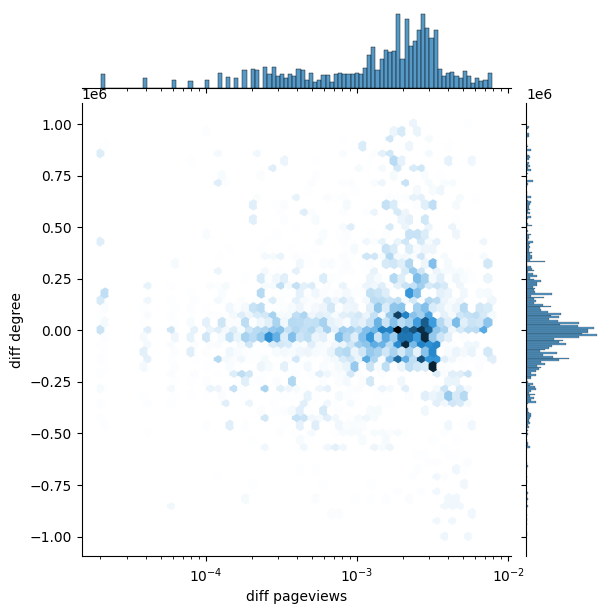

In [31]:
recenter = ab_test_degree.loc[np.abs(ab_test_degree.diff_pageviews) < 1000000]
g = sns.jointplot(x=recenter.degree_centrality1 - recenter.degree_centrality2,
              y=recenter.diff_pageviews, kind="hex",
              xscale="log")
g.set_axis_labels("diff pageviews", "diff degree")
